# MD Protein-Ligand System preparation

**Sample notebook** with the overall pipeline to prepare a simulation system containing the CDK2 protein bound to a ligand.

In [1]:
import subprocess
import os 
import shutil
from pathlib import Path
import warnings
import nglview
import ipywidgets
import sys
sys.path.append('..')
import plotly
import nglview
from plotly import subplots
import plotly.graph_objs as go
%load_ext autoreload
%autoreload 2

### Define the system properties
- **Initial structure:** `1fin` ([pdb entry](https://www.rcsb.org/structure/1FIN)). 
    - `1fin_A_mod.pdb`: This structure was prepared using Modeller.
- **Solvent:** `WAT` (water).
- **Box type:** Truncated Octahedron
    - Padding: 12 Angstroms 
- **Salt concentration:** 0.15 M

- **Ligand:** `ATP`
- **pH for ionizable residues and ligand protonation:** 7.4

In [2]:
PDB_ID       = '1fin'
LIG_NAME     = 'ATP'
SOLVENT_TYPE = 'TIP3PBOX'
PH           = 7.4
BOX_PADDING  = 12.0
ION_MOLAR    = 0.15

# Output basename
FINAL_BASENAME = f'{PDB_ID}-LIG'

# Define the input files
WD = f'./../data/md_system_prep/LIG_systems/{PDB_ID}'
INPUT_PROT     = f'{WD}/{PDB_ID}_A_mod.pdb'
INPUT_LIG      = f'{WD}/{PDB_ID}_{LIG_NAME}_LIG.pdb'
INPUT_CRYS_WAT = f'{WD}/{PDB_ID}_CRYS_WAT.pdb'
LIG_RESNAME    = f'LIG'
LIG_PARTIAL_CHARGES = 'gasteiger'

### Visualize the input structures

In [3]:
view = nglview.show_structure_file(INPUT_PROT)
view.add_component(INPUT_LIG)
view.add_component(INPUT_CRYS_WAT)
view.clear_representations()
view[0].add_representation('cartoon', selection='protein', color='sstruc')
view[1].add_representation('ball+stick')
view[2].add_representation('licorice')
view._remote_call('setSize', target='Widget', args=['','400px'])
view.camera='orthographic'
view

NGLWidget()

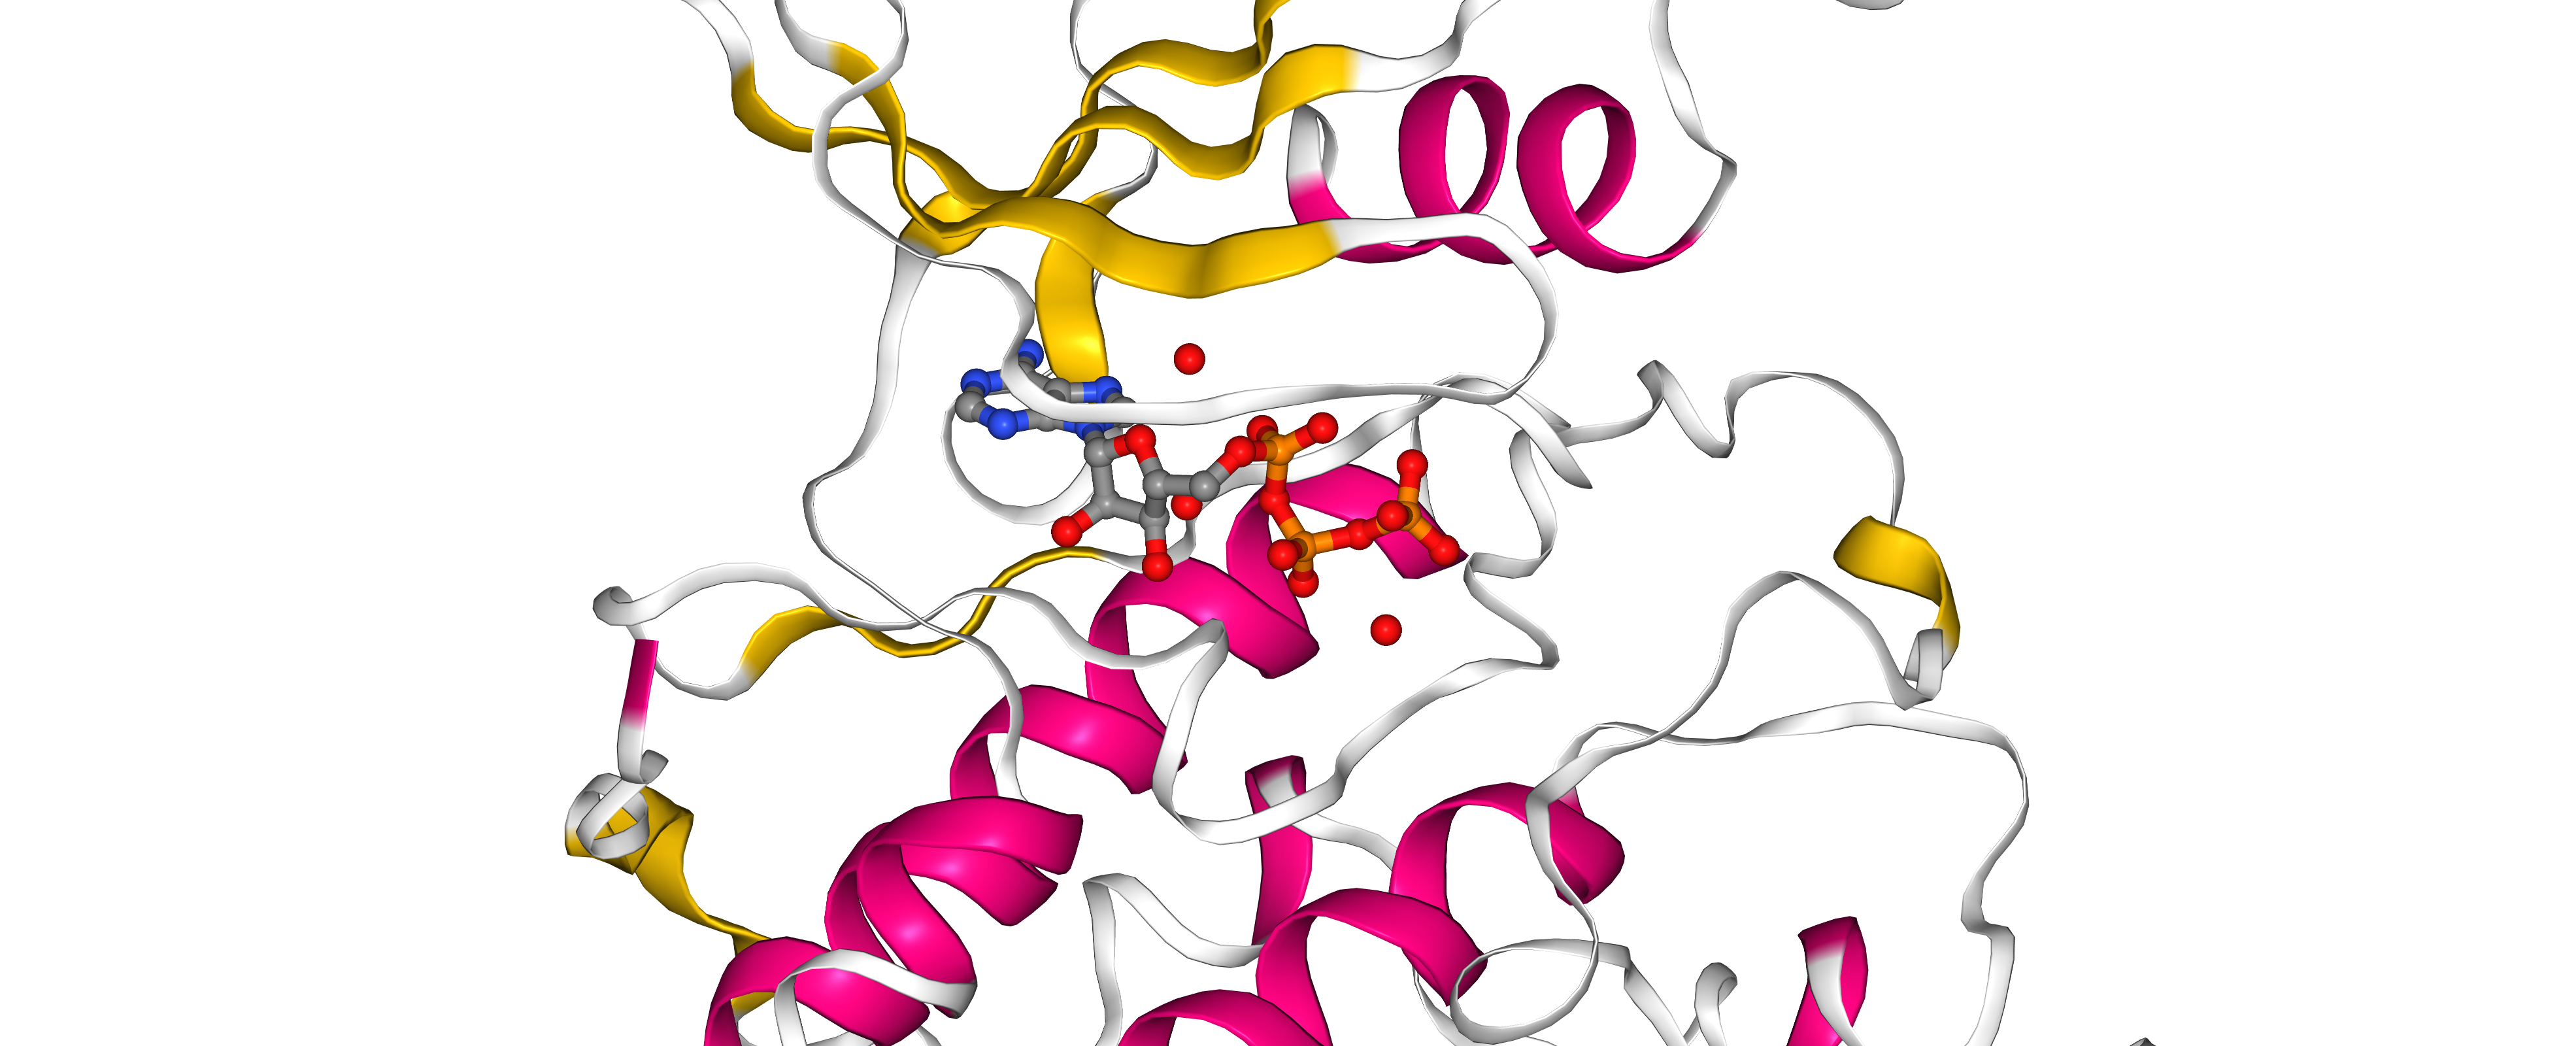

In [6]:
view.render_image()
view._display_image()

- Create a directory to save intermediate files:

In [7]:
# Create a folder to store intermediate files
TMP_DIR = f'{WD}/{FINAL_BASENAME}_intermediate_files'
Path(TMP_DIR).mkdir(exist_ok = True)

## Prepare the protein using `PDB2PQR`

```bash
pdb2pqr30 --ff='AMBER' --ffout='AMBER'\
    --with-ph=${ph} -o=${ph}\
    --drop-water --keep-chain\
    --log-level='INFO'\
    --titration-state-method='propka'\
    --pdb-output ${output_basename}.pdb\
    ${input_pdb} ${output_basename}.pqr
```

In [8]:
# Prepare the protein using PDB2PQR
from helper_modules.prepare_md_system import run_pdb2pqr
OUT_PDB2PQR = 'prot.TEMP'
run_pdb2pqr(input_pdb = INPUT_PROT,  
            output_basename = f'{TMP_DIR}/{OUT_PDB2PQR}',
            ph = PH,
            verbose = True)

INFO:PDB2PQR v3.4.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: ./../data/md_system_prep/LIG_systems/1fin/1fin_A_mod.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: 'Ato'
ERROR:<REMARK AtomGroup 1fin_A_mod>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Dropping water from structure.
INFO:Setting up molecule.
INFO:Created biomolecule object with 298 residues and 2398 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:This biomolecule is 

## Prepare the Ligand

### Convert from `pdb` to `mol2`
- Use `obabel` to convert from `pdb` to `mol2`

```bash
obabel -ipdb ${input_ligand} \
       -omol2 -O ${output_name} \
       --partialcharge ${partial_charges}
```

In [10]:
# Convert ligand to mol2
# LIG ************************************************
from helper_modules.prepare_md_system import run_obabel
OUT_OBABEL = 'OUT_OBABEL.LIG.mol2'
run_obabel(input_ligand = INPUT_LIG, 
           output_name = f'{TMP_DIR}/{OUT_OBABEL}', 
           ph = PH, 
           use_amber_reduce = False,
           partial_charges = LIG_PARTIAL_CHARGES)

1 molecule converted

None


In [11]:
view = nglview.show_structure_file(f'{TMP_DIR}/{OUT_OBABEL}')
view.add_representation(repr_type='ball+stick')
view._remote_call('setSize', target='Widget')
view.camera='orthographic'
view

NGLWidget()

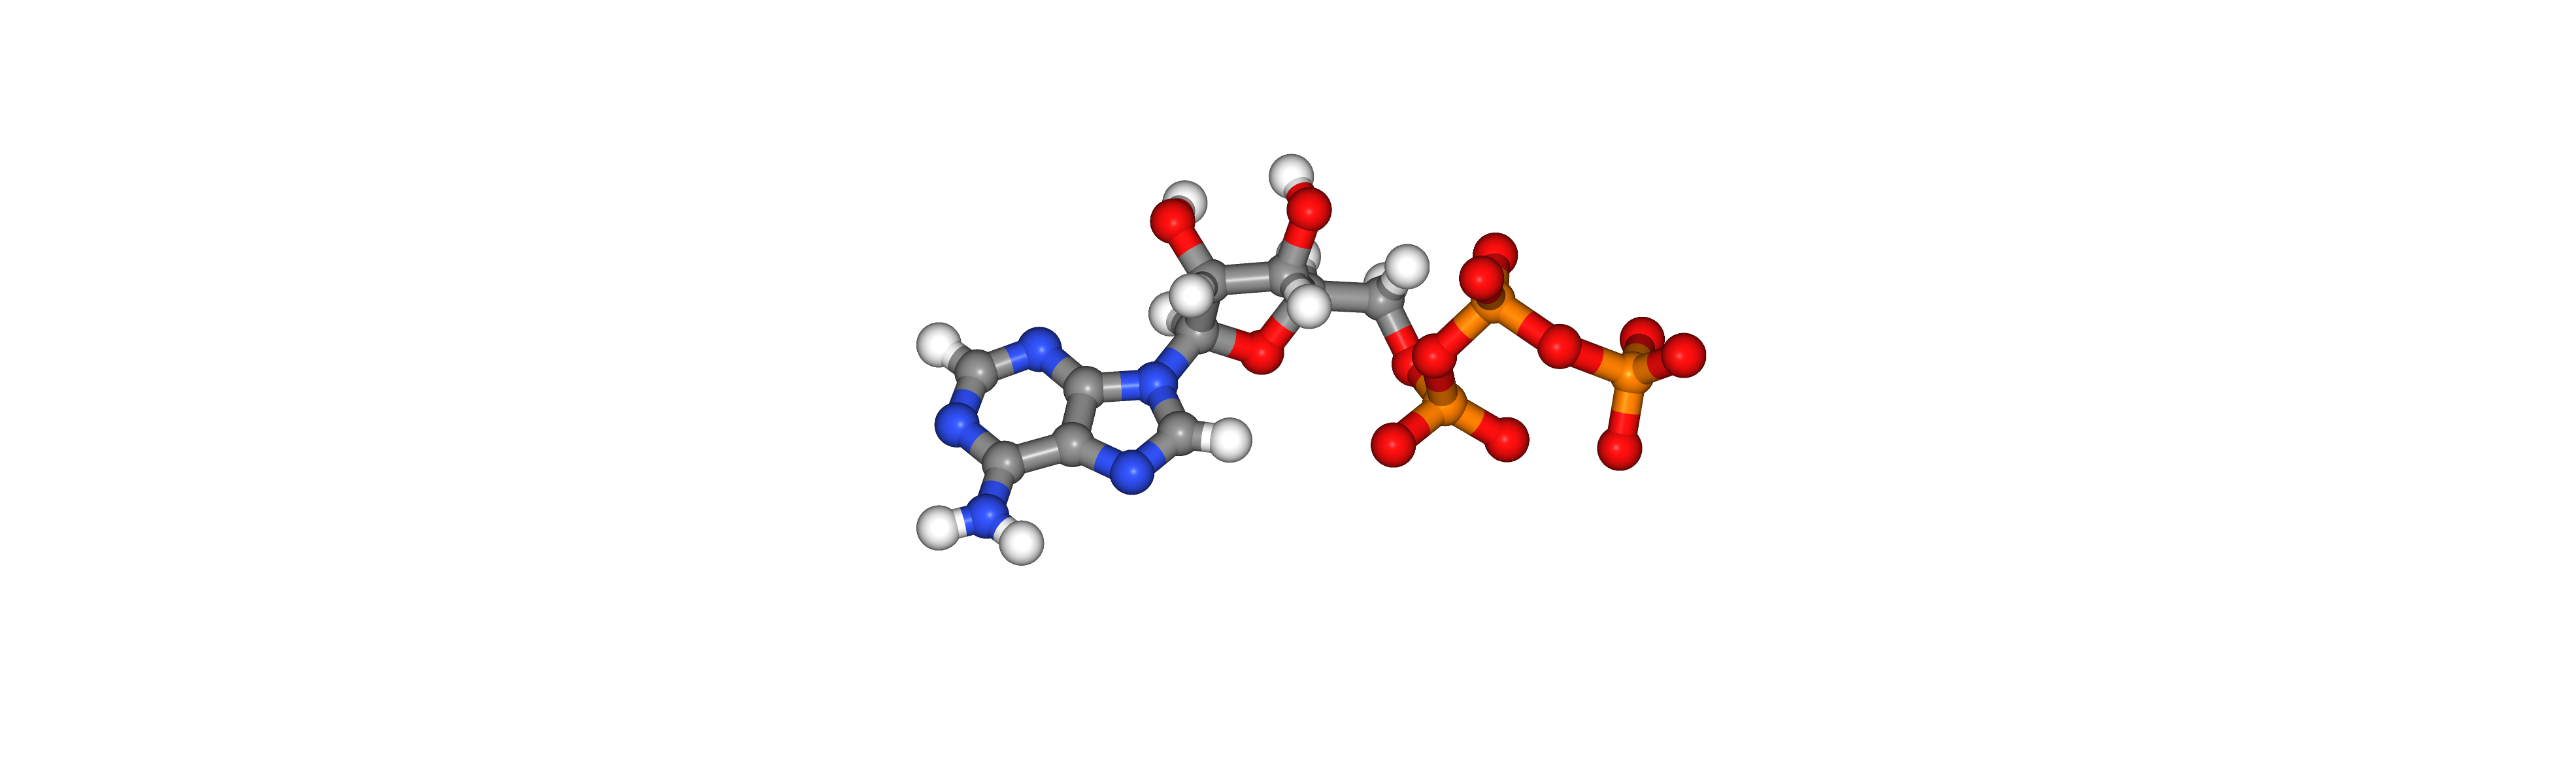

In [13]:
view.render_image()
view._display_image()

### Estimate the net charge of the molecule
- Use the **partial charges** estimated by `obabel`.
    - This approach is similar to that implemented by [ACPYPE](https://bmcresnotes.biomedcentral.com/articles/10.1186/1756-0500-5-367)
- ⚠️ <mark>WARNING:</mark> This value has to be corroborrated by the user.

In [14]:
# Get the net charge of the ligand
from helper_modules.prepare_md_system import run_get_charge 
LIG_NET_CHARGE = run_get_charge(
                    filename = f"{TMP_DIR}/{OUT_OBABEL}", 
                    round_value = True 
)
print(f'{LIG_NAME} net charge:', LIG_NET_CHARGE)

ATP net charge: -4


### Create ligand topology using Antechamber and GAFF

- Run [Antechamber](http://ambermd.org/antechamber/ac.html) to assign atom types using `GAFF`, and compute partial charges using the [AM1-BCC2](https://pubmed.ncbi.nlm.nih.gov/12395429/) charge method:

```bash
antechamber -i ${mol2_filename} + \
            -fi mol2 -o ${output_dir}/LIG.mol2 + \
            -fo mol2 -c bcc -s 2 -at gaff2 -eq 2 + \
            -rn ${lig_resname} + \
            -nc ${lig_net_charge}
```

- Run `parmchk2` to check for missing force field parameters:

```bash
parmchk2 -i {mol2_filename} \
         -f mol2 -o {frcmod_filename} \
         -s gaff2
```

In [15]:
# Run antechamber
from helper_modules.prepare_md_system import run_antechamber
run_antechamber(mol2_filename  = f'{TMP_DIR}/{OUT_OBABEL}', 
                lig_resname    = LIG_RESNAME,
                lig_net_charge = LIG_NET_CHARGE,
                output_dir     = TMP_DIR)


Welcome to antechamber 20.0: molecular input file processor.

acdoctor mode is on: check and diagnose problems in the input file.
-- Check Format for mol2 File --
   Status: pass
Info: Finished reading file (./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/OUT_OBABEL.LIG.mol2); atoms read (43), bonds read (45).
Info: Determining atomic numbers from atomic symbols which are case sensitive.
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
         the connectivity (2) for atom type (N.ar) defined in CORR_NAME_TYPE.DAT.
But, you may safely ignore the warnings if your molecule
         uses atom names or element names as atom types.
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Running: /Users/joelricci/miniconda/envs/biobb/bin/bondtype -j full -i ANTECHAMBER_BOND_

Verify the net charge of the `LIG.mol2` file.

In [16]:
# Verify the net charge of the `LIG.mol2` file
from helper_modules.prepare_md_system import run_get_charge 
LIG_NET_CHARGE = run_get_charge(
                    filename = f"{TMP_DIR}/LIG.mol2", 
                    round_value = False 
)
print(f'{LIG_NAME} (LIG.mol2) net charge:', LIG_NET_CHARGE)

ATP (LIG.mol2) net charge: -4.0


In [17]:
!tail $TMP_DIR/sqm.out

  QMMM:    37       37      H      -12.9292  208.0576  114.8253
  QMMM:    38       38      H      -10.7195  208.6422  116.4432
  QMMM:    39       39      H      -10.1168  206.7907  114.7555
  QMMM:    40       40      H      -16.1411  205.5307  118.6880
  QMMM:    41       41      H      -10.2422  207.3045  107.8478
  QMMM:    42       42      H      -11.7354  207.2526  108.5173
  QMMM:    43       43      H       -7.5419  205.3701  111.1073

           --------- Calculation Completed ----------



### Verify the `LIG.frcmod` file

- Confirm that there are no parameters with the comment `ATTN: needs revision`, as they will require manual revision.

In [18]:
!cat $TMP_DIR/LIG.frcmod

Remark line goes here
MASS

BOND

ANGLE

DIHE

IMPROPER
c3-ca-na-cc         1.1          180.0         2.0          Using the default value
h5-na-cc-nd         1.1          180.0         2.0          Same as X -X -ca-ha, penalty score= 67.5 (use general term))
ca-ca-ca-nd         1.1          180.0         2.0          Using the default value
ca-nb-ca-nh         1.1          180.0         2.0          Using the default value
ca-hn-nh-hn         1.1          180.0         2.0          Same as X -X -na-hn, penalty score= 41.2 (use general term))
h5-nb-ca-nb         1.1          180.0         2.0          Same as X -X -ca-ha, penalty score= 44.6 (use general term))
ca-na-ca-nb         1.1          180.0         2.0          Using the default value

NONBON





In [20]:
# Prepare the LIG params library

from helper_modules.prepare_md_system import run_leap_lig_lib
run_leap_lig_lib(tmp_dir      = TMP_DIR, 
                 lig_basename = LIG_RESNAME)

-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/prep to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/lib to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/parm to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd to search path.
-f: Source ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/leap_lig_lib.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/leap_lig_lib.in
----- Source: /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.gaff
----- Source of /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.gaff done
Log file: ./leap.log
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/gaff.dat
Reading title:
AMBER General Force Field for organic molecules (Version 1.81, May 2017)
Loading parameters: ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/LIG.fr

## Protein-Ligand Complex set up

In [21]:
# Create the complex

from helper_modules.prepare_md_system import run_tleap_prepare_pl_complex 
OUT_SYSTEM = 'COMPLEX'
run_tleap_prepare_pl_complex(output_basename  = OUT_SYSTEM, 
                             tmp_dir          = TMP_DIR, 
                             input_waters_pdb = INPUT_CRYS_WAT)

-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/prep to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/lib to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/parm to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd to search path.
-f: Source ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/leap_prep_complex.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/leap_prep_complex.in
----- Source: /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/frcmod.ff1

### Minimize Hydrogens

In [22]:
# Minimize Hydrogens using sander

from helper_modules.prepare_md_system import run_minimize_hydrogens
OUT_MIN_SYSTEM = 'COMPLEX.minH'
run_minimize_hydrogens(input_basename = OUT_SYSTEM, 
                       output_basename = OUT_MIN_SYSTEM,
                       tmp_dir = TMP_DIR,
                       verbose = True)


None


In [23]:
from biobb_amber.process.process_minout import process_minout

process_minout(input_log_path  = f'{TMP_DIR}/sander.minH.log',
               output_dat_path = f'{TMP_DIR}/sander.minH.dat',
               properties      = {'terms': ['ENERGY']})

with open(f'{TMP_DIR}/sander.minH.dat', 'r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy kcal/mol")
                       )
}

plotly.offline.iplot(fig)

2022-04-06 20:52:19,514 [MainThread  ] [INFO ]  Creating command line with instructions and required arguments
2022-04-06 20:52:19,672 [MainThread  ] [INFO ]  process_minout.perl  ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/sander.minH.log

2022-04-06 20:52:19,673 [MainThread  ] [INFO ]  Exit code 0

2022-04-06 20:52:19,674 [MainThread  ] [INFO ]  Processing sander output file (./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/sander.minH.log)...
Processing step 50 of a possible 500...
Processing step 100 of a possible 500...
Processing step 150 of a possible 500...
Processing step 200 of a possible 500...
Processing step 250 of a possible 500...
Processing step 300 of a possible 500...
Processing step 350 of a possible 500...
Processing step 400 of a possible 500...
Processing step 450 of a possible 500...
Processing step 500 of a possible 500...
Processing step 500 of a possible 500...
Starting output...
Outputing summary.NSTEP
Outputing 

## Solvate the System

- `water_type` = `tip3p` water model
- `box_type` = truncated octahedron 
- Padding distance of 1.2 nm.

In [24]:
# Solvate the System

from helper_modules.prepare_md_system import run_leap_solv
OUT_PL_SOLV  = 'SOLV'
run_leap_solv(input_basename  = OUT_MIN_SYSTEM,
              output_basename = OUT_PL_SOLV, 
              box_padding     = BOX_PADDING,
              solvent_type    = SOLVENT_TYPE,
              input_ligand_basename = 'LIG',
              tmp_dir = TMP_DIR)

-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/prep to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/lib to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/parm to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd to search path.
-f: Source ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/leap_prep_SOLV.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/leap_prep_SOLV.in
----- Source: /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/frcmod.ff14SB
Re

## Neutralize the system using NaCl
- Get the number of water molecules inside the system
- In this example, the **net charge** of the protein is <mark>+4</mark> and the net charge of the ligand is <mark>-4</mark>.
- We only need to add the same number of Na+ and Cl- ions to achieve the desired NaCl concentration.


In [25]:
# Neutralize the System

from helper_modules.prepare_md_system import run_leap_neutralization
OUT_PL_NEUTRAL = 'NEUTRAL'
run_leap_neutralization(input_basename    = OUT_PL_SOLV, 
                        output_basename   = OUT_PL_NEUTRAL, 
                        tmp_dir           = TMP_DIR, 
                        solvent_type      = SOLVENT_TYPE,
                        input_ligand_basename = 'LIG',
                        ion_concentration = ION_MOLAR)

-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/prep to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/lib to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/parm to search path.
-I: Adding /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd to search path.
-f: Source ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/leap_prep_NEUTRAL.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./../data/md_system_prep/LIG_systems/1fin/1fin-LIG_intermediate_files/leap_prep_NEUTRAL.in
----- Source: /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /Users/joelricci/miniconda/envs/biobb/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /Users/joelricci/miniconda/envs/biobb/dat/leap/parm/frcmod.ff1

In [26]:
view = nglview.show_structure_file(f'{TMP_DIR}/{OUT_PL_NEUTRAL}.pdb')
view.clear_representations()
view.add_representation(repr_type ='cartoon', selection='protein')
view.add_representation(repr_type ='licorice', selection='LIG')
view.add_representation(repr_type ='spacefill', selection='Cl- Na+')
view._remote_call('setSize', target='Widget', args=['','600px'])
view

NGLWidget()

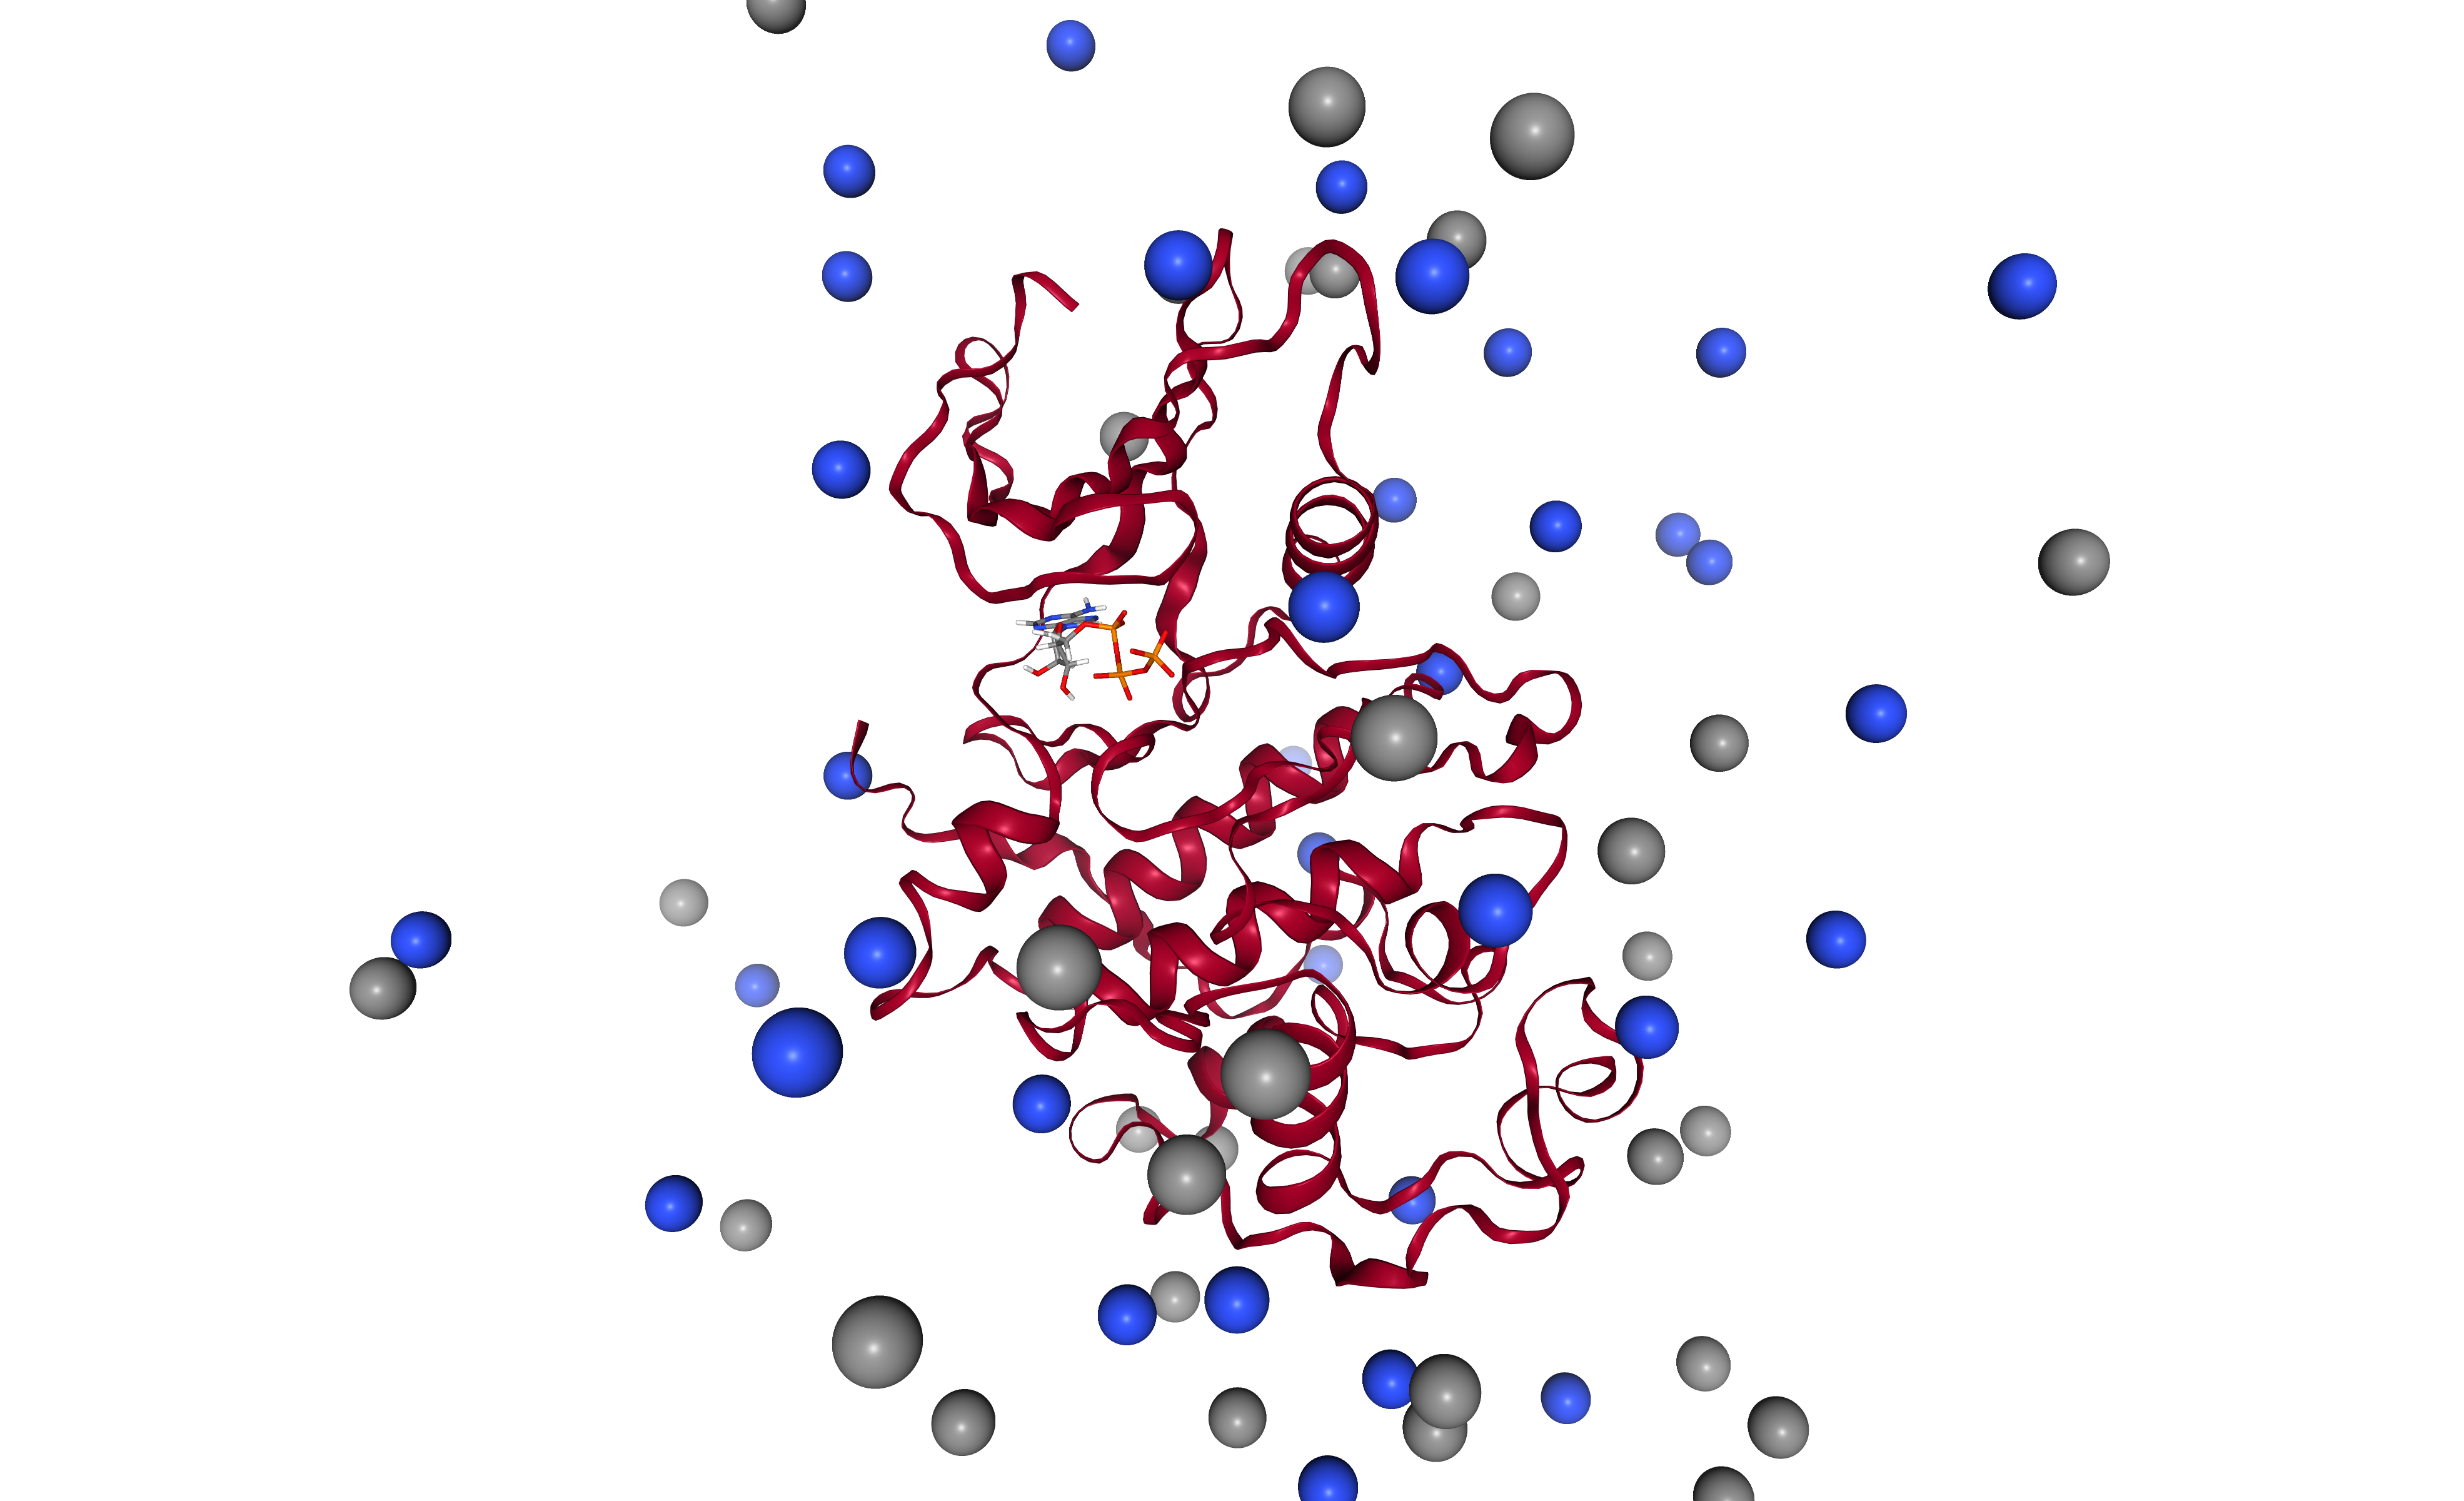

In [28]:
view.render_image()
view._display_image()

### Center the system to the origin

In [29]:
from helper_modules.prepare_md_system import run_center_system_to_origin

run_center_system_to_origin(
            filename = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.rst7',
            topology = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.prmtop',
            out_filename = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.CENTERED.rst7')

Moving system to origin (45.02, 50.81, 53.50) -> (0,0,0)


## Use `ParmEd` to convert from Amber to Gromacs 

In [30]:
# Conver to gromacs
import parmed as pmd

top  = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.prmtop'
rst7 = f'{TMP_DIR}/{OUT_PL_NEUTRAL}.CENTERED.rst7.1'

amber = pmd.load_file(top, rst7)
#save a GROMACS topology and GRO file
TOP_FILE = f'{TMP_DIR}/{FINAL_BASENAME}_NO_POSRES.top'
FINAL_GRO_FILE = f'{WD}/{FINAL_BASENAME}.gro'
amber.save(TOP_FILE)
amber.save(FINAL_GRO_FILE)

In [31]:
from parmed.gromacs import GromacsTopologyFile
top = GromacsTopologyFile(TOP_FILE)
top.molecules.keys()

dict_keys(['system1', 'LIG', 'Na+', 'Cl-', 'WAT'])

### Include `posres.itp` to the topology file

#### For the protein
- Include the following lines inside the `.top` file, just below the protein definition
```algol60
; Include Position restraint file for protein
#ifdef POSRES
#include "${BASENAME}.prot_posre.itp"
#endif
```

#### For the ligand
- Include the following lines inside the `.top` file, just below the protein definition
```algol60
; Include Position restraint file for protein
#ifdef POSRES
#include "${BASENAME}.lig_posre.itp"
#endif
```

In [32]:
from helper_modules.prepare_md_system import include_posre_in_top, create_posre_file

FINAL_TOP_FILE = f'{WD}/{FINAL_BASENAME}.top'
# Protein posres
PROT_POSRE_FILE = f'{FINAL_BASENAME}.prot_posre.itp'
create_posre_file(input_gro          = FINAL_GRO_FILE, 
                  out_posre_filename = f'{WD}/{PROT_POSRE_FILE}',
                  mol_selection      = 'protein',
                  rest_energies      = [1000, 1000, 1000],
                  verbose = False)
include_posre_in_top(input_top_file = TOP_FILE, 
                     out_top_file   = FINAL_TOP_FILE, 
                     posre_filename = PROT_POSRE_FILE,
                     molecule_index = 1 # inx=1 for protein
                    )

# Ligand posres
LIG_POSRE_FILE = f'{FINAL_BASENAME}.lig_posre.itp'
create_posre_file(input_gro          = FINAL_GRO_FILE, 
                  out_posre_filename = f'{WD}/{LIG_POSRE_FILE}',
                  mol_selection      = 'ligand',
                  rest_energies      = [1000, 1000, 1000],
                  verbose = False)
include_posre_in_top(input_top_file = FINAL_TOP_FILE, 
                     out_top_file   = FINAL_TOP_FILE, 
                     posre_filename = LIG_POSRE_FILE,
                     molecule_index = 2 # inx=2 for ligand
                    )

### Print some properties of the final system

In [33]:
# Get the protein charge
import re

def get_log_lines(file, 
                  pattern, 
                  lines_list = [0]):
    log_lines = []
    with open(file,"r") as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if re.search(pattern, line):
                for j in lines_list:
                    log_lines.append(lines[i + j])
    return log_lines



In [34]:
# Report Logs
file = f'{TMP_DIR}/leap_prep_{OUT_SYSTEM}.in.log'

# Protein charge
pattern = 'charge protein'
protein_charge = get_log_lines(file, pattern, lines_list = [1])
protein_charge = protein_charge[0].replace('\n', '').split(' ')[-1]
protein_charge= [f'\nProtein Net Charge: {protein_charge}']

# Total protein atoms
pattern = 'total atoms in file'
n_protein_atoms = get_log_lines(file, pattern, lines_list = [0])
n_protein_atoms = n_protein_atoms[0].strip().split(' ')[-1]
n_protein_atoms = [f'\nNumber of Protein atoms: {n_protein_atoms}']


file = f'{TMP_DIR}/leap_prep_{OUT_PL_NEUTRAL}.in.log'

# Total protein atoms
pattern = 'total atoms in file'
n_total_atoms = get_log_lines(file, pattern, lines_list = [0])
n_total_atoms = n_total_atoms[0].strip().split(' ')[-1]
n_total_atoms = [f'\nTotal Number of atoms: {n_total_atoms}']

# System charge
pattern = 'charge system'
system_charge = get_log_lines(file, pattern, lines_list = [1])
system_charge = system_charge[0].replace('\n', '').split(' ')[-1]
system_charge = [f'\nSystem Net Charge: {system_charge}']

# Box dimensions
pattern = 'Box dimensions'
box_dimensions = get_log_lines(file, pattern, lines_list = [0])
box_dimensions = box_dimensions[0].split(' ')[-3:]
box_dimensions = [f'- {c}: {b}\n' for b, c in zip(box_dimensions, ['x', 'y', 'z'])]
box_dimensions.insert(0, pattern + ':\n')

# Warnings
pattern = 'Warning!'
warnings = get_log_lines(file, pattern, lines_list = [1])
warnings.insert(0, '\nWarnings:')

# Number of final waters
pattern = '\tWAT'
n_waters = get_log_lines(file, pattern, lines_list = [0])
n_waters = [n_waters[0].strip()]
n_waters.insert(0, '\nNumber of WAT molecules:')

# Number of ions
pattern = 'Placed Na+'
n_Na = [str(len(get_log_lines(file, pattern, lines_list = [0])))]
n_Na.insert(0, '\nNumber of Na+ ions:')

pattern = 'Placed Cl-'
n_Cl = [str(len(get_log_lines(file, pattern, lines_list = [0])))]
n_Cl.insert(0, '\nNumber of Cl- ions:')

# Number of cosolvent molecules
solv_lines = []
SOLVENT = 'WAT'
if SOLVENT != None and SOLVENT != 'WAT':
    pattern = f'\t{SOLVENT}'
    solv_lines = get_log_lines(file, pattern, lines_list = [0])
    solv_lines = [solv_lines[0].strip()]
    solv_lines.insert(0, f'\nNumber of {SOLVENT} molecules:')
    
LINES = protein_charge + system_charge + n_protein_atoms + n_total_atoms +\
        n_waters + solv_lines +\
        n_Na + n_Cl + box_dimensions + warnings
        
with open(f'{TMP_DIR}/PREP_SUMMARY.log', 'w') as f:
    f.writelines(LINES)
    
for l in LINES:
    print(l)


Protein Net Charge: 4.000000

System Net Charge: -0.000000

Number of Protein atoms: 4848

Total Number of atoms: 45898

Number of WAT molecules:
WAT	13595

Number of Na+ ions:
37

Number of Cl- ions:
37
Box dimensions:

- x: 90.054600

- y: 102.805600

- z: 106.668600



Warnings:
Close contact of 1.419804 angstroms between .R<GLU 73>.A<HG3 10> and .R<ASN 74>.A<H 2>

Close contact of 1.338882 angstroms between .R<GLU 224>.A<OE2 13> and .R<THR 231>.A<HG1 12>

 Converting N-terminal residue name to PDB format: NMET -> MET

 Converting C-terminal residue name to PDB format: CLEU -> LEU

